In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Exploratory Data Analysis

[Change the link]

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/getting-started/intro_gemini_1_5_flash.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Fgetting-started%2Fintro_gemini_1_5_flash.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/getting-started/intro_gemini_1_5_flash.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/getting-started/intro_gemini_1_5_flash.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>


## Overview

[add overview]

[add what you learned in previous notebook and link] - skip if its first


[Context of this notebook compared to overall idea]

## Getting Started

### Install Dependencies


In [1]:
! pip3 install --upgrade --user --quiet google-cloud-aiplatform
! pip3 install --user --quiet pydub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 23.0 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

In [ ]:
import sys

if "google.colab" in sys.modules:
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the cell below to authenticate your environment.


In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [ ]:
# Define project information
PROJECT_ID = "mlops-for-genai"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}
BUCKET_NAME = "mlops-for-genai" # @param {type:"string"}
# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

# Initialize cloud storage
from google.cloud import storage

storage_client = storage.Client(project=PROJECT_ID)
bucket = storage_client.bucket(BUCKET_NAME)

### Import libraries


In [ ]:
import IPython.display
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from vertexai.generative_models import (
    GenerationConfig,
    GenerativeModel,
    HarmBlockThreshold,
    HarmCategory,
    Part,
)

from google.cloud import storage
import io
from pydub import AudioSegment
import pandas as pd
from typing import List, Dict, Optional
import json
from google.cloud import storage

### Load the models

To learn more about all [Gemini API models on Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/models#gemini-models).


In [ ]:
MODEL_ID_PRO = "gemini-1.5-pro-001"  # @param {type:"string"}
MODEL_ID_FLASH = "gemini-1.5-flash-001" # @param {type:"string"}

model_pro = GenerativeModel(MODEL_ID_PRO)
model_flash = GenerativeModel(MODEL_ID_FLASH)

### Add data path

In [ ]:
prototype_data = "multimodal-finanace-qa/data/unstructured/prototype/"  # @param {type:"string"}
production_data = "multimodal-finanace-qa/data/unstructured/production/"  # @param {type:"string"}

In [ ]:
#@title Gemini API Function

def get_gemini_response(
    model,
    generation_config: Optional[GenerationConfig] = None,
    safety_settings: Optional[Dict[HarmCategory, HarmBlockThreshold]] = None,
    uri_path: Optional[str] = None,
    mime_type: Optional[str] = None,
    prompt: Optional[str] = None
) -> str:
    """
    Generates a response using the Gemini AI model, optionally incorporating
    external file content and applying safety settings.

    Args:
        model: The Gemini AI model instance.
        generation_config: Configuration for text generation (e.g., temperature, token limit).
        safety_settings: Settings to determine blocking thresholds for harmful content categories.
        uri_path: The URI of an external file to include in the generation.
        mime_type: The MIME type of the external file (e.g., "text/plain", "image/jpeg").
        prompt: An optional text prompt to guide the generation.

    Returns:
        The generated text response from the Gemini model.
    """

    if not generation_config:
        generation_config = GenerationConfig(
            max_output_tokens=8192,
            temperature=1,
            top_p=0.95,
        )

    if not safety_settings:
        safety_settings = {
            HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_ONLY_HIGH,
            HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
            HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
            HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        }

    file = Part.from_uri(mime_type=mime_type, uri=uri_path)

    responses: List[GenerateContentResponse] = model.generate_content(
        [file, prompt],
        generation_config=generation_config,
        safety_settings=safety_settings,
        stream=True,
    )
    final_response: List[str] = []

    for response in responses:
        try:
            final_response.append(response.text)
        except ValueError:
            # Handle blocked content
            final_response.append("blocked")

    return "".join(final_response)

## Exploring Prototype Data




### Overall files

In [ ]:
for blob in bucket.list_blobs():
  if blob.name.startswith(prototype_data):
    print(blob.name)

multimodal-finanace-qa/data/unstructured/prototype/alphabet_2023_q4_earnings_call.mp3
multimodal-finanace-qa/data/unstructured/prototype/goog-10-q-q2-2023-4-1-15.pdf
multimodal-finanace-qa/data/unstructured/prototype/google_cloud_tpu_blog_training.pdf
multimodal-finanace-qa/data/unstructured/prototype/google_gemini_intro_video.mp4
multimodal-finanace-qa/data/unstructured/prototype/google_responsible_ai.mp4
multimodal-finanace-qa/data/unstructured/prototype/google_search_next_phase_with_ai.mp4


### Audio files

In [ ]:
#@title Audio Feature Extraction Helper Functions

audio_sentiment_analysis_prompt = f"""Analyze the sentiment of the following audio.
Extract the following:
1) Provide the overall sentiment as positive, negative, or neutral.
2) Extract the top 5 phrases that most strongly contribute to the overall sentiment.
3) Extract the top 10 most relevant keywords.
4) Identify the different speakers present.
5) Summarize the audio in 3-5 concise sentences. Focus on the main points, key findings, and overall takeaways.

Expected Output Format:
      {{
  "overall_sentiment": "positive/negative/neutral",
  "contributing_phrases": [
    "phrase 1",
    "phrase 2",
    "phrase 3",
    "phrase 4",
    "phrase 5"
  ],
  "keywords": [
    "keyword 1",
    "keyword 2",
    ...,
    "keyword 10"
  ],
  "speakers": [
    "speaker 1",
    "speaker 2",
    ...,
    "speaker 5"
  ],
  "summary": "summary of the audio"
}}
"""

def get_blob_uri(bucket_name: str, blob_name: str) -> str:
    """Gets the full URI of the blob in Google Cloud Storage.

    Args:
        bucket_name: The name of the GCS bucket.
        blob_name: The name of the blob within the bucket.

    Returns:
        The full GCS URI (gs://...) of the blob.
    """
    return f"gs://{bucket_name}/{blob_name}"


def analyze_audio(audio_bytes: io.BytesIO) -> Dict:
    """Analyzes audio data using PyDub and extracts metadata.

    Args:
        audio_bytes: An in-memory bytes buffer containing the audio data.

    Returns:
        A dictionary containing audio metadata (duration, size, sampling rate, channels).
    """
    try:
        audio = AudioSegment.from_file(audio_bytes, format="mp3")
    except AudioSegment.CouldntDecodeError as e:
        raise ValueError("Could not decode audio file (ensure it's MP3 format).") from e

    return {
        "duration_in_min": audio.duration_seconds / 60,
        "size_in_mb": len(audio_bytes.getvalue()) / (1024 * 1024),
        "sampling_rate_in_hz": audio.frame_rate,
        "channels": audio.channels,
    }


def analyze_audio_in_gcs(
    bucket: storage.Bucket, prototype_data: str, audio_analysis_prompt: str
) -> pd.DataFrame:
    """Analyzes MP3 audio files from a Google Cloud Storage bucket that match a prototype.

    Args:
        bucket: A GCS Bucket object.
        prototype_data: The prefix to filter blobs in the bucket.
        audio_analysis_prompt: The prompt to use for Gemini audio analysis.

    Returns:
        A Pandas DataFrame containing analysis results for each matching audio file.
    """

    audio_metadata = []

    for blob in bucket.list_blobs():
        if blob.name.startswith(prototype_data) and blob.name.endswith(".mp3"):
            audio_bytes = io.BytesIO()
            blob.download_to_file(audio_bytes)
            audio_bytes.seek(0)

            metadata = analyze_audio(audio_bytes)
            audio_analysis = get_gemini_response(
                        model=model_flash,  # Replace with your actual model
                        uri_path=get_blob_uri(bucket.name, blob.name),
                        mime_type="audio/mp3",
                        prompt=audio_analysis_prompt,
                    )
            json_string = audio_analysis[8:-3]
            audio_analysis_data = json.loads(json_string)

            metadata.update(
                {
                    "blob_name": blob.name.split("/")[-1],
                    "blob_path": get_blob_uri(bucket.name, blob.name),
                    "overall_sentiment": audio_analysis_data["overall_sentiment"],
                    "contributing_phrases": audio_analysis_data["contributing_phrases"],
                    "keywords": audio_analysis_data["keywords"],
                    "speakers": audio_analysis_data["speakers"],
                    "summary": audio_analysis_data["summary"],
                }
            )
            audio_metadata.append(metadata)

    return pd.DataFrame(audio_metadata), audio_analysis_data

important to highlight that we are leveraging Gemini Flash to extract features from audio.

In [ ]:
%%time

analysis_df, audio_analysis_data = analyze_audio_in_gcs(bucket,
                                                        prototype_data,
                                                        audio_sentiment_analysis_prompt)

CPU times: user 3.24 s, sys: 3.63 s, total: 6.87 s
Wall time: 47.4 s


In [ ]:
analysis_df

,duration_in_min,size_in_mb,sampling_rate_in_hz,channels,blob_name,blob_path,overall_sentiment,contributing_phrases,keywords,speakers,summary
0,56.861412,104.11844,44100,2,alphabet_2023_q4_earnings_call.mp3,gs://mlops-for-genai/multimodal-finanace-qa/da...,positive,[I'm happy with what we are seeing in the earl...,"[AI, search, YouTube, Google Cloud, revenue, g...","[Operator, Jim Friedland, Sundar Pichai, Phill...",Alphabet's fourth-quarter 2023 earnings call d...


In [ ]:
index = 0
print("Total time of audio (in minute): ", analysis_df['duration_in_min'][index])
print("Size of audio (in MB):", analysis_df['size_in_mb'][index])
print("Sampling rate of audio (in Hertz): ", analysis_df['sampling_rate_in_hz'][index])
print("Channels of audio: ", analysis_df['channels'][index])

Total time of audio (in minute):  56.8614119425548
Size of audio (in MB): 104.11843967437744
Sampling rate of audio (in Hertz):  44100
Channels of audio:  2


In [ ]:
print("Overall sentiment of audio:", analysis_df['overall_sentiment'][index])
print("\nContributing phrases of audio:")
analysis_df['contributing_phrases'][index]
print("\nKeywords of audio:")
analysis_df['keywords'][index]
print("\nSpeakers of audio:")
analysis_df['speakers'][index]
print("\nSummary of audio:")
analysis_df['summary'][index]

Overall sentiment of audio: positive

Contributing phrases of audio:


["I'm happy with what we are seeing in the earliest days of SGE",
 "I'm excited for what's ahead in 2024",
 "We're very pleased with the momentum of GCP with an increasing contribution from AI",
 "We're very pleased with our full-year results with 2023 Alphabet revenues of 370 billion up 9% versus 2022",
 "We're also pleased with our first season of NFL Sunday Ticket"]


Keywords of audio:


['AI',
 'search',
 'YouTube',
 'Google Cloud',
 'revenue',
 'growth',
 'subscription',
 'advertising',
 'products',
 'investments']


Speakers of audio:


['Operator',
 'Jim Friedland',
 'Sundar Pichai',
 'Phillip Schindler',
 'Ruth Porat',
 'Brian Nowak',
 'Doug Ammouth',
 'Eric Sheridan',
 'Justin Post',
 'Mark Mahaney']


Summary of audio:


"Alphabet's fourth-quarter 2023 earnings call discussed their strong momentum and product innovation, particularly in AI, which is helping to drive growth in search, subscriptions, and cloud. They highlighted the new Gemini AI model and its impact on various products and services. They also discussed their continued investments in technical infrastructure and their commitment to re-engineering their cost base. They are excited about the continued growth opportunities in 2024."

<Figure size 800x800 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

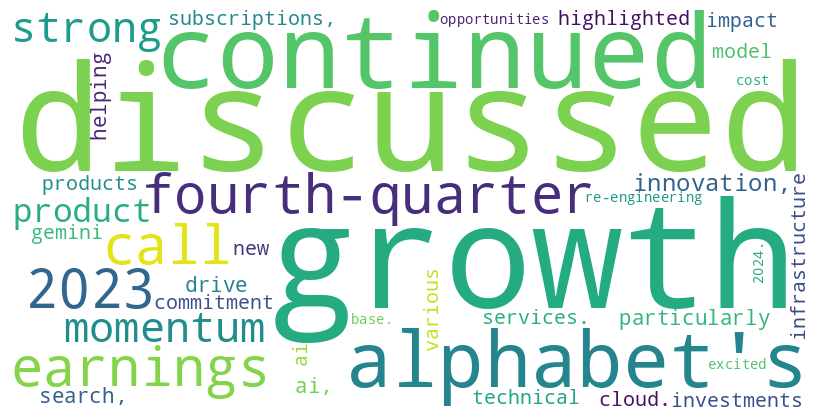

In [ ]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter


list1 = analysis_df['keywords'][index]
list2 = analysis_df['speakers'][index]
long_text  =  analysis_df['summary'][index]
# Combine lists into a single text string
all_words = ' '.join(list1 +list2) + long_text

# Preprocessing long text
# 1. Tokenization (splitting into words)
words = long_text.lower().split()

# 2. Stopword removal (remove common, less meaningful words)
stopwords = set(STOPWORDS)
stopwords.update(["will", "is", "are"]) # Add more stopwords relevant to your text
words = [word for word in words if word not in stopwords]

# 3. Count word frequencies
word_counts = Counter(words)

# Generate WordCloud, giving higher weights to more frequent words from long text
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=stopwords,
    min_font_size=10
).generate_from_frequencies(word_counts)

# Display the generated image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Conclusion

[add conclusions & Next Steps]